In [10]:
!pip install yfinance scikit-learn pandas numpy streamlit
!pip install prophet


[*********************100%***********************]  1 of 1 completed
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing


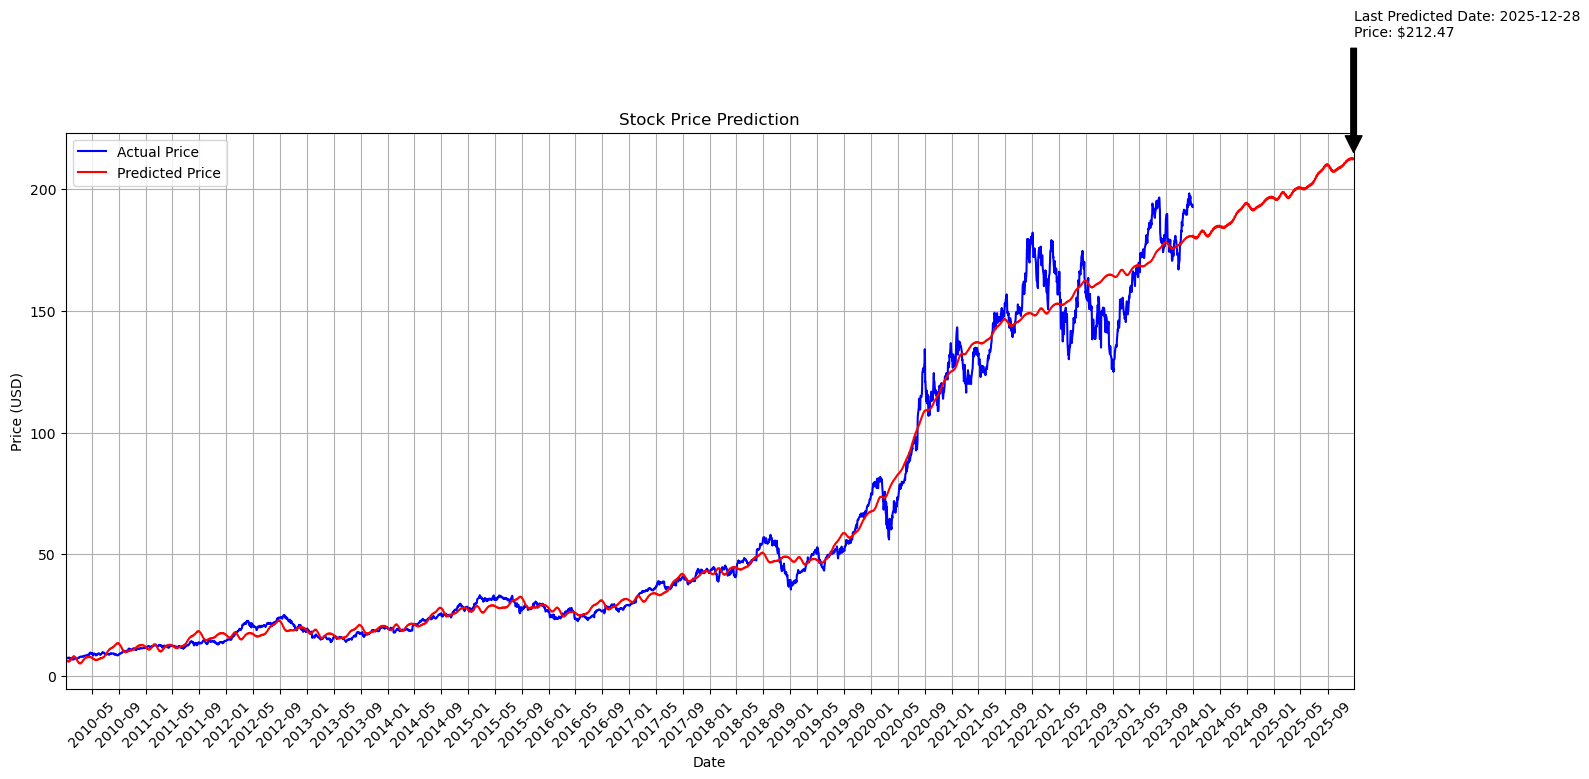

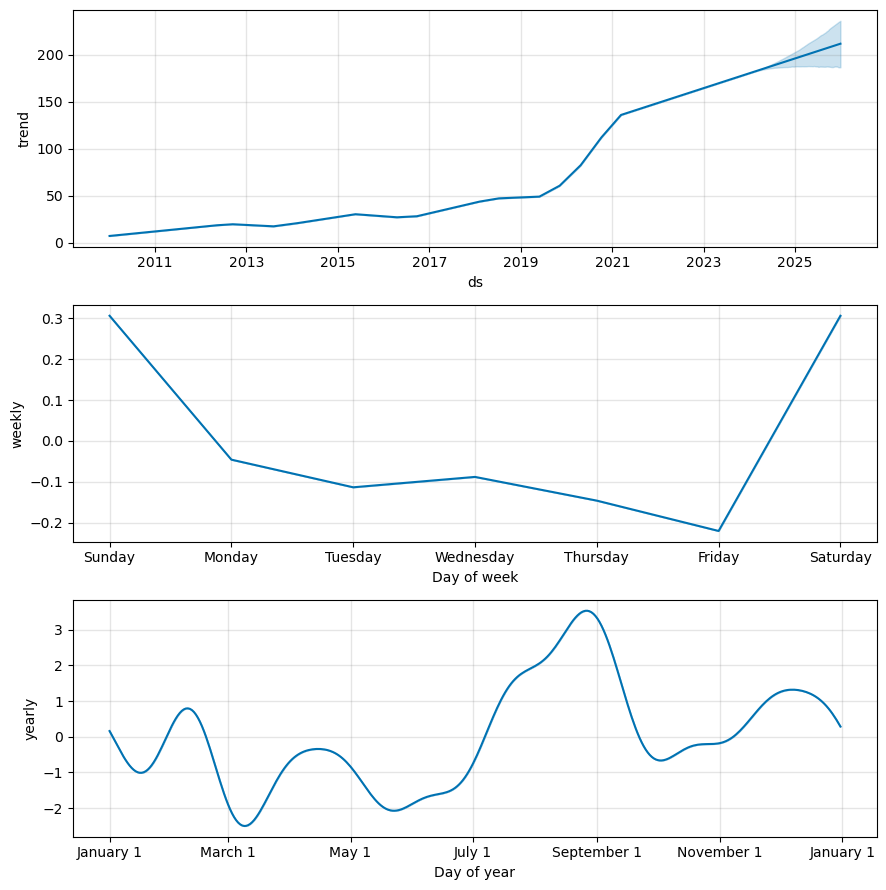

In [24]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fetch stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

# Flatten MultiIndex
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

# Prepare data for Prophet
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.rename(columns={'Date': 'ds', 'Close_AAPL': 'y'}, inplace=True)

# Check for missing or infinite values in 'y'
data = data.dropna(subset=['y'])  # Remove rows with missing 'y' values
data = data[~data['y'].isin([np.inf, -np.inf])]  # Remove rows with infinite 'y' values

# Convert 'y' to numeric type
data['y'] = pd.to_numeric(data['y'])

# Initialize and fit the Prophet model
model = Prophet()
model.fit(data)

# Function to predict and plot future prices
def predict_and_plot(model, periods=730):
    # Make future dataframe for predictions
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    # Plot the forecast
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(data['ds'], data['y'], label='Actual Price', color='blue')
    ax.plot(forecast['ds'], forecast['yhat'], label='Predicted Price', color='red')
    
    # Format the date axis for better readability
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    # Highlight the last predicted date
    last_date = forecast['ds'].iloc[-1]
    last_price = forecast['yhat'].iloc[-1]
    ax.annotate(f'Last Predicted Date: {last_date.strftime("%Y-%m-%d")}\nPrice: ${last_price:.2f}', 
                xy=(last_date, last_price), xytext=(last_date, last_price + 50),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.set_xlim([data['ds'].min(), future['ds'].max()])
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.set_title('Stock Price Prediction')
    ax.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the forecast components (trend, weekly, yearly seasonality)
    fig2 = model.plot_components(forecast)
    
    # Save the forecast to a CSV file
    forecast.to_csv('stock_price_forecast.csv', index=False)

# Call the function to predict and plot
predict_and_plot(model)
